In [30]:
import pandas as pd
import os
import random
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import transforms
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider

<h2>Loading captions into a dataframe<h2>

In [2]:
#open csv file
df = pd.read_csv(r"..\dataset\flickr30k_images\results.csv",delimiter="|")

#convert to lowercase and remove whitespace str.lower() is used instead of lower() as we have a 
#pandas series here and we want to apply the operation to every string. It is an vectorized 
# operation
df[" comment"] = df[" comment"].str.lower().str.strip()
df = df[df[" comment"].notna()]                    # Remove NaN
df = df[df[" comment"] != ""]  
#remove duplicate same caption for same image
df = df.drop_duplicates(subset=["image_name"," comment"])

df


,image_name,comment_number,comment
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"two young , white males are outside near many ..."
2,1000092795.jpg,2,two men in green shirts are standing in a yard .
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .
4,1000092795.jpg,4,two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,a man in shorts and a hawaiian shirt leans ove...
158911,998845445.jpg,1,"a young man hanging over the side of a boat , ..."
158912,998845445.jpg,2,a man is leaning off of the side of a blue and...
158913,998845445.jpg,3,"a man riding a small boat in a harbor , with f..."


<h2> Accessing a row <h2>

In [3]:
image_name = df.iloc[0]["image_name"]
caption = df.iloc[0][" comment"]
image_name,caption

('1000092795.jpg',
 'two young guys with shaggy hair look at their hands while hanging out in the yard .')

<h2> Creating a dictionary of images and their captions</h2>

In [4]:
caption_dict = defaultdict(list)
#accessing element not in default dict will not return error,
#  it creates default value([] here)

for _,row in df.iterrows():
    caption_dict[row["image_name"]].append(row[" comment"])

In [5]:
for item in caption_dict.items():
    print(item)
    break

('1000092795.jpg', ['two young guys with shaggy hair look at their hands while hanging out in the yard .', 'two young , white males are outside near many bushes .', 'two men in green shirts are standing in a yard .', 'a man in a blue shirt standing in a garden .', 'two friends enjoy time spent together .'])


<h2> Vocabulary Class <h2>

The vocabulary class is used to collect all words used in the dataset of captions. It collects the words and assigns a unique index to each words and also to the special tokens. This is later used for tokenization, converting words to numeric tensors

In [6]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.freqs = Counter()
        self.special_tokens = ["<start>","<end>","<unk>","<pad>"]

    def build_vocab(self, caption_dict, threshold=5):
        for captions in caption_dict.values():
            for caption in captions:
                if not isinstance(caption, str):
                    continue
                words = caption.lower().strip().split()
                self.freqs.update(words)

        for idx, token in enumerate(self.special_tokens):
            self.word2idx[token] = idx
            self.idx2word[idx] = token
            idx += 1

        idx = len(self.special_tokens)

        for word, freq in self.freqs.items():
            if freq >= threshold:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1


    def __getitem__(self, word):
        return self.word2idx.get(word, self.word2idx["<unk>"])

    def __len__(self):
        return len(self.word2idx)
    
    def idx_to_word(self, index):
        return self.idx2word.get(index, "<unk>")
    
    def decode_caption(self, token_ids):
        words = []

        for token_id in token_ids:
            #token_id = token_id.item()
            word = self.idx_to_word(token_id)

            if word == "<end>":
                break

            if word not in ["<start>", "<pad>"]:
                words.append(word)

        caption = " ".join(words)
        return caption
    
    def decode_captions_debugger(self, token_ids):
        words = []

        for token_id in token_ids:
            #token_id = token_id.item()
            word = self.idx_to_word(token_id)
            words.append(word)
        return words


vocab - It maps words to unique numerical IDs, so captions can be converted into tensors.<br>
self.vocab = {<br>
    "&lt;pad&gt;": 0,<br>
    "&lt;start&gt;": 1,<br>
    "&lt;end&gt;": 2,<br>
    "&lt;unk&gt;": 3,<br>
    "a": 4,<br>
    "man": 5,<br>
    "is": 6,<br>
    ...<br>
}<br>
<br>
🔧 In training:<br>
"a man is playing guitar" -> [1, 4, 5, 6, 7, 8, 2]  # <start> a man is playing guitar <end><br>

<h2>Dataset class</h2>

Handles image by image processing of datasets. Each image is processed, tokenization is done for captions. Any image transformations if needed are applied.

In [7]:
class Flickr30kDataset(Dataset):

    def __init__(self, image_dir, caption_dict, vocab, transform=None):
        self.image_dir = image_dir
        self.caption_dict = list(caption_dict.items()) # [(image_name, [captions])]
        self.vocab = vocab #dictionary of all words used with index allocated for each word
        self.transform = transform #transformations to be applied for images

    def __len__(self):#returns number of images present
        return len(self.caption_dict)

    def __getitem__(self, idx): #What Happens on dataset[i]
        image_name, captions = self.caption_dict[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")#to ensure image has 3 channels

        #one caption is chosen at random, but over many epoch all captions will be choosed
        caption = random.choice(captions) 

        #tokenization words into numerical tensors
        tokens = [self.vocab["<start>"]]
        tokens += [self.vocab[word] for word in caption.split()]
        tokens += [self.vocab["<end>"]]

        #apply image transformations
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(tokens)


<h2> Collator class </h2>

Images are processed as batch. All the images are stacked here to form a batch of data.
<br>Applies padding to each caption, to make length of all captions equal to the length of longest caption.

In [8]:

class Collator:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images, captions = zip(*batch)

        #pad sequences 
        lengths = [len(caption) for caption in captions]
        captions_padded = pad_sequence(captions, batch_first = True, padding_value=self.pad_idx)

        return torch.stack(images), captions_padded, torch.tensor(lengths)

<h2> Data splitting <h2>

In [9]:
items = sorted(caption_dict.items(), key=lambda x:x[0])
seed = 42

train_set, temp_set = train_test_split(items, test_size=0.25,random_state=seed)
val_set, test_set = train_test_split(temp_set, test_size=0.5,random_state=seed)

train_dict = dict(train_set)
val_dict = dict(val_set)
test_dict = dict(test_set)

In [10]:
for item in train_dict.items():
    print(len(train_dict))
    print(item)
    break

for item in val_dict.items():
    print(len(val_dict))
    print(item)
    break

for item in test_dict.items():
    print(len(test_dict))
    print(item)
    break

23837
('2741990005.jpg', ['a high jumper goes at his craft , leaping over the pole as a bright sky of blue and occasional white clouds pass overhead .', 'there is a man or woman attempting the high jump on a mostly clear day , it looks like they are about to clear the pole .', 'a woman jumping over a bar during the day .', 'an olympic jumper crossing the rope .', 'a man vaults over a high bar .'])
3973
('3632225464.jpg', ['a person is flying in the air with a building to the left of him .', 'a person hangs from ropes high in the air next to a building .', 'a person suspended by a bungee cord jumps off a building .', 'a skydiver flies through the air near a tall building .', 'the bungee jumper jumps off a tall building .'])
3973
('640290673.jpg', ['seven people in yellow and black matching outfits are pushing yellow and black carts on wheels around in the middle of hundreds of people .', 'a group of people in yellow and black uniforms performing in front of a large crowd .', 'an audienc

<h2> Data Loading </h2>

In [11]:
#1. Image Transformations
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225]),
])
#2. Vocabulary building

#add pickle file
vocab_path = r"..\extras\vocabulary.pkl"

if os.path.exists(vocab_path):
    print("Loading Existing Vocabulary....")
    with open(vocab_path, "rb") as f:
        vocab = pickle.load(f)

else:
    print("Creating new Vocabulary....")
    vocab = Vocabulary()
    vocab.build_vocab(caption_dict=caption_dict,
                  threshold=4)
    with open(vocab_path, "wb") as f:
        pickle.dump(vocab, f)


#3. Collate function
collator = Collator(pad_idx=vocab["<pad>"])


Loading Existing Vocabulary....


In [12]:
print(len(vocab))

8640


In [13]:
#4. Creating dataset
train_dataset = Flickr30kDataset(image_dir=r"..\dataset\flickr30k_images\Images",
                           caption_dict=train_dict,
                           vocab=vocab,
                           transform=transform)

val_dataset = Flickr30kDataset(image_dir=r"..\dataset\flickr30k_images\Images",
                           caption_dict=val_dict,
                           vocab=vocab,
                           transform=transform)

test_dataset = Flickr30kDataset(image_dir=r"..\dataset\flickr30k_images\Images",
                           caption_dict=test_dict,
                           vocab=vocab,
                           transform=transform)
#5. Dataloader
train_loader = DataLoader(dataset=train_dataset,
                        batch_size=32,
                        shuffle=True,
                        collate_fn=collator)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=32,
                        shuffle=False,
                        collate_fn=collator)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=32,
                        shuffle=False,
                        collate_fn=collator)

In [14]:
print(len(train_dataset), len(val_dataset), len(test_dataset))
for idx in range(len(train_dataset)):
    image, caption = train_dataset[idx]
    # image will be a transformed image tensor
    # caption will be a tensor of token indices
    print(f"Image shape: {image.shape}")
    print(f"Caption tensor: {caption}")
    print(f"Max value: {image.amax(dim=(1,2))}, Min value: {image.amin(dim=(1,2))}")
    print(f"Mean: {image.mean(dim=(1,2))}, Std: {image.std(dim=(1,2))}")
    break

23837 3973 3973
Image shape: torch.Size([3, 224, 224])
Caption tensor: tensor([   0,   33,  159,  178,  179,   33, 2399,  699,   18,  653,   20,    1])
Max value: tensor([2.2318, 2.4111, 2.6226]), Min value: tensor([-2.1179, -2.0357, -1.8044])
Mean: tensor([-0.0598,  0.4042,  1.0950]), Std: tensor([0.9883, 0.9660, 0.8808])


In [15]:
for images, captions, lengths in train_loader:
    print("Image batch shape:", images.shape)
    print("Captions shape:", captions.shape)    
    print("Lengths:", lengths)
    print("Image:",images)
    print("Caption: ", captions)
    break

Image batch shape: torch.Size([32, 3, 224, 224])
Captions shape: torch.Size([32, 27])
Lengths: tensor([13, 10, 14, 15, 27, 11, 15, 14, 13, 17, 16, 15, 13,  9, 22, 20, 16, 11,
        18,  9, 16, 10, 14, 21, 14, 22, 14, 11, 25, 13, 18, 12])
Image: tensor([[[[ 0.6563,  0.6563,  0.7077,  ...,  0.2282,  0.2453,  0.2624],
          [ 0.5364,  0.5536,  0.5878,  ...,  0.1768,  0.2282,  0.2967],
          [ 0.5193,  0.6221,  0.6049,  ...,  0.2796,  0.2453,  0.2282],
          ...,
          [-0.1828, -0.1828, -0.1657,  ..., -0.0801, -0.0458,  0.0056],
          [-0.1143, -0.1657, -0.1828,  ..., -0.0287, -0.0287, -0.0116],
          [-0.1486, -0.1657, -0.1999,  ..., -0.0116, -0.0629, -0.0629]],

         [[ 0.6429,  0.6604,  0.7304,  ...,  0.2927,  0.3277,  0.3452],
          [ 0.6254,  0.6604,  0.7129,  ...,  0.2577,  0.3102,  0.3803],
          [ 0.5903,  0.7129,  0.7129,  ...,  0.3803,  0.3452,  0.3102],
          ...,
          [ 0.1702,  0.1702,  0.1702,  ...,  0.1877,  0.1877,  0.2402],
 

<h2> Encoder <h2>

The image is converted into a feature vector, by removing the classification layer and converting the output into desired 2-d vector, using a linear layer, with output size equal to embedding_size.

In [16]:
class EncoderCNN(nn.Module):

    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(weights="IMAGENET1K_V1")
        for param in resnet.parameters():
            param.requires_grad = False#freezing gradients, transfer learning   

        modules = list(resnet.children())[:-1] #removing last layer
        self.resnet = nn.Sequential(*modules) #combining remaining layers
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)#resizing to embedding size
        self.bn = nn.BatchNorm1d(embed_size)

    def forward(self, images):
        features = self.resnet(images)  # (B, 2048, 1, 1)
        features = features.view(features.size(0), -1)  # (B, 2048)
        features = self.bn(self.linear(features))  # (B, embed_size)
        return features

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)  # (B, T, embed_size)

        # Use image features to initialize LSTM states
        h0 = self.init_h(features).unsqueeze(0)  # (1, B, hidden_size)
        c0 = self.init_c(features).unsqueeze(0)  # (1, B, hidden_size)

        # Pack sequence
        packed = nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        hiddens, _ = self.lstm(packed, (h0, c0))
        outputs = self.linear(hiddens.data)

        return outputs

    
    def sample(self, features, max_length = 30):
        output_ids = []
            # Initialize hidden and cell state using image features
        h0 = self.init_h(features).unsqueeze(0)  # (1, B, hidden_size)
        c0 = self.init_c(features).unsqueeze(0)  # (1, B, hidden_size)
        states = (h0, c0)

        # Start with <start> token
        start_tokens = torch.tensor([vocab["<start>"]] * features.size(0), device=features.device)
        inputs = self.embed(start_tokens).unsqueeze(1)
# (B, 1, embed_size)

        for _ in range(max_length):
            hidden, states = self.lstm(inputs, states)
            outputs = self.linear(hidden.squeeze(1)) #(B,1,D) -> (B,vocab_size)
            predicted = outputs.argmax(1) #(B,)
            output_ids.append(predicted)

            inputs = self.embed(predicted) #(B,embed_size)
            inputs = inputs.unsqueeze(1) #(B,1,embed_size)

        output_ids = torch.stack(output_ids, 1)
        return output_ids


In [18]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions, lengths):
        features = self.encoder(images)  # (B, embed_size)
        outputs = self.decoder(features, captions, lengths)
        return outputs


In [40]:
# gts: ground truths, res: model results
# Each dict should map image_id -> list of 1+ captions

def evaluate_metrics(gts, res):
    scorers = [
        (Bleu(4), ["BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4"]),
        #(Meteor(), "METEOR"),
        (Cider(), "CIDEr"),
    ]
#for bleu we get list of scores. So , we zip the scores along with names of scores.
    results = {}

    for scorer, method in scorers:
        score, scores_per_instance = scorer.compute_score(gts, res)
        if isinstance(method, list):
            for m, s in zip(method, score):
                results[m] = s #each bleu score is stored seperately in the dictionary
        else:
            results[method] = score #other methods and scores are stored as key-value pairs

    return results


In [20]:
def generate_caption(model, image, vocab, device, transform = None, max_length=30):
    """
    Generates a caption string from a single image tensor using the model.
    """
    model.eval()
    if transform:
        image = transform(image)
    image = image.unsqueeze(0).to(device)  # (1, C, H, W)

    with torch.no_grad():
        # Encode image features
        features = model.encoder(image)  # (1, embed_size)

        # Generate token IDs using decoder
        sampled_ids = model.decoder.sample(features, max_length=max_length)  # (1, max_len)
        sampled_ids = sampled_ids[0].tolist()  # Remove batch dim → list of ints

        # Convert IDs to words
        caption = vocab.decode_caption(sampled_ids)
    
    return caption

<h2>Training Loop</h2>

In [21]:
#1. Hyperparameters
num_epochs = 10
learning_rate = 1e-3
pad_idx = vocab["<pad>"]
embed_size = 256
hidden_size = 512

#2. Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


encoder = EncoderCNN(embed_size=embed_size)
decoder = DecoderRNN(embed_size=embed_size, hidden_size=hidden_size, vocab_size=len(vocab))
model = ImageCaptioningModel(encoder=encoder, decoder=decoder)


#3. Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)


In [42]:
def train_model(model, train_loader,val_loader, criterion, optimizer, vocab, num_epochs, device, clip_value=10):
    model.to(device=device)

    for epoch in range(1, num_epochs+1):

        # ---------------------- TRAINING ----------------------
        model.train() #to make model run in train mode
        train_loss = 0 #used to track average loss per epoch

        for batch_idx, (image_batch, captions, lengths) in enumerate(train_loader):
            image_batch = image_batch.to(device)
            captions = captions.to(device)

            adjusted_lengths = [l-1 for l in lengths]
            #Targets: all words except the first one <start>
            targets = nn.utils.rnn.pack_padded_sequence(input=captions[:,1:],
                                                        lengths=adjusted_lengths,
                                                        batch_first=True,
                                                        enforce_sorted=False,
                                                        )[0]
            #Outputs: generated from models
            outputs = model(image_batch, captions[:, :-1], torch.tensor(adjusted_lengths))

            #compute loss
            loss = criterion(outputs, targets)

            #reset gradient to zero
            optimizer.zero_grad()

            #compute gradients
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            #Update weights based on gradients
            optimizer.step()

            train_loss += loss.item() #accumulate epoch loss

            #batch loss
            if (batch_idx ) % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        #average loss in an epoch     
        avg_train_loss = train_loss / len(train_loader)


        # ---------------------- VALIDATION ----------------------
        model.eval()
        val_loss = 0
        gts = {}
        res = {}

        with torch.no_grad():
            for i,(images, captions, lengths) in enumerate(val_loader):
                images = images.to(device)
                captions = captions.to(device)
                adjusted_lengths = [l-1 for l in lengths]
                # ---------- Compute Loss ----------
                targets = nn.utils.rnn.pack_padded_sequence(
                    captions[:, 1:], adjusted_lengths,
                    batch_first=True, enforce_sorted=False
                )[0]

                outputs = model(images, captions[:, :-1], adjusted_lengths)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                
                # ---------- Compute Captions for Metrics ----------
                for j in range(images.size(0)):
                    image = images[j]
                    image_id = i * val_loader.batch_size + j #Compute Unique Image ID

                    # Ground truth (only the first caption is used per image)
                    gt_caption_ids = captions[j].tolist()
                    gt_caption = vocab.decode_caption(gt_caption_ids)
                    gts[image_id] = [gt_caption]  # Wrap in list as required

                    # Model prediction
                    predicted_caption = generate_caption(model, image, vocab, device)

                    if predicted_caption and isinstance(predicted_caption, str) and predicted_caption.strip():
                        res[image_id] = [predicted_caption]
                    else:
                        res[image_id] = ["<unk>"]  # fallback safe caption
                    
        avg_val_loss = val_loss / len(val_loader)
            
        # ---------------------- SUMMARY ----------------------
        print(f"\nEpoch [{epoch}/{num_epochs}] Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss  : {avg_val_loss:.4f}\n")
        if (epoch==1) or (epoch%4 == 0):
            print("--- Evaluation Metrics ---")
            metrics = evaluate_metrics(gts, res)
            for metric, score in metrics.items():
                print(f"{metric}: {score:.4f}")



In [23]:
train_model(model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            vocab=vocab,
            num_epochs=num_epochs,
            device=device,
            clip_value=10)


Epoch [1/10], Step [1/745], Loss: 9.0615
Epoch [1/10], Step [101/745], Loss: 4.3434
Epoch [1/10], Step [201/745], Loss: 3.9882
Epoch [1/10], Step [301/745], Loss: 3.7443
Epoch [1/10], Step [401/745], Loss: 3.8125
Epoch [1/10], Step [501/745], Loss: 3.7134
Epoch [1/10], Step [601/745], Loss: 3.7307
Epoch [1/10], Step [701/745], Loss: 3.3042

Epoch [1/10] Summary:
  Train Loss: 3.9691
  Val Loss  : 3.4615

--- Evaluation Metrics ---
{'testlen': 55449, 'reflen': 53553, 'guess': [55449, 51476, 47503, 43530], 'correct': [17055, 3675, 1135, 432]}
ratio: 1.0354041790375696
BLEU-1: 0.3076
BLEU-2: 0.1482
BLEU-3: 0.0807
BLEU-4: 0.0478
CIDEr: 0.2339
Epoch [2/10], Step [1/745], Loss: 3.3745
Epoch [2/10], Step [101/745], Loss: 3.1026
Epoch [2/10], Step [201/745], Loss: 3.3863
Epoch [2/10], Step [301/745], Loss: 3.1519
Epoch [2/10], Step [401/745], Loss: 3.1828
Epoch [2/10], Step [501/745], Loss: 3.3551
Epoch [2/10], Step [601/745], Loss: 3.2374
Epoch [2/10], Step [701/745], Loss: 3.3821

Epoch [2/1

In [44]:
def evaluate_model(model, test_loader, vocab, criterion, device):
    model.eval()
    test_loss = 0
    gts = {}
    res = {}

    with torch.no_grad():
        for i,(images, captions, lengths) in enumerate(test_loader):
            images = images.to(device)
            captions = captions.to(device)

            adjusted_lengths = [l - 1 for l in lengths]
            # ---------- Compute Loss ----------
            targets = nn.utils.rnn.pack_padded_sequence(
                captions[:, 1:], adjusted_lengths,
                batch_first=True, enforce_sorted=False
            )[0]

            outputs = model(images, captions[:, :-1], adjusted_lengths)

            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # ---------- Compute Captions for Metrics ----------
            for j in range(images.size(0)):
                image = images[j]
                image_id = i * test_loader.batch_size + j #Compute Unique Image ID

                # Ground truth (only the first caption is used per image)
                gt_caption_ids = captions[j].tolist()
                gt_caption = vocab.decode_caption(gt_caption_ids)
                gts[image_id] = [gt_caption]  # Wrap in list as required

                # Model prediction
                predicted_caption = generate_caption(model, image, vocab, device)
                res[image_id] = [predicted_caption]

    # ---------- Compute Evaluation Metrics ----------
    metrics = evaluate_metrics(gts, res)

    avg_test_loss = test_loss / len(test_loader)
    print(f"\nTest Loss: {avg_test_loss:.4f}")
    print("--- Evaluation Metrics ---")
    for metric, score in metrics.items():
        print(f"{metric}: {score:.4f}")

    return avg_test_loss, metrics


In [45]:
test_loss, metrics = evaluate_model(model, test_loader, vocab, criterion, device)

{'testlen': 53085, 'reflen': 53442, 'guess': [53085, 49112, 45139, 41166], 'correct': [17914, 4049, 1260, 480]}
ratio: 0.9933198607836348

Test Loss: 2.9129
--- Evaluation Metrics ---
BLEU-1: 0.3352
BLEU-2: 0.1657
BLEU-3: 0.0913
BLEU-4: 0.0545
CIDEr: 0.3142


In [ ]:
# Save
torch.save(model.state_dict(), r"..\checkpoints\basic_lstm_model.pth")

# Load
# model.load_state_dict(torch.load(r"..\checkpoints\basic_lstm_model.pth"))
# model.to(device)


Predicted Caption:
a group of people are sitting in a circle eating .


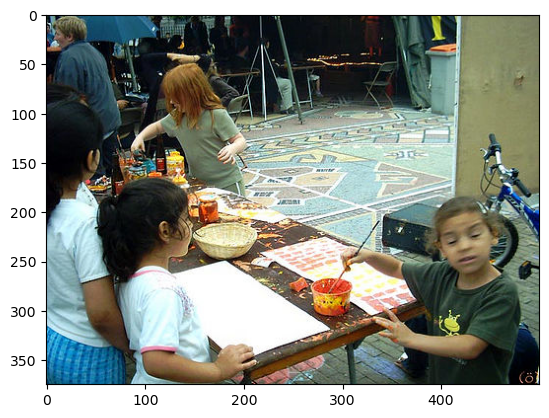

In [36]:
image_path = r"..\dataset\flickr30k_images\Images\438106.jpg"  # Replace with your image file path

# Load and preprocess the image
image = Image.open(image_path).convert('RGB')

# Generate caption
caption = generate_caption(model, image, vocab, device, transform=transform)

# Print result
print("Predicted Caption:")
print(caption)
plt.imshow(image)
